# ECSE 415: Assignment 3
## Imad Dodin | 260713381
### Notes:

* Only libraries installed in the tutorials were used in this assignment - for simplicity, I've frozen them into requirements.txt for the grader's reference.
* Following instructions on the assignment, images and directories are expected to be placed on the same directory as this file and named identically to the starter directory provided. 

### Acknowledgements: 
I refer to code from the class tutorials to accomplish the required tasks, due to this my code is very similar to code provided in tutorials to accomplish similar tasks as here. All comments are my own work.

## 1. Segmentation 
### 1.1 K-means Clustering

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import math

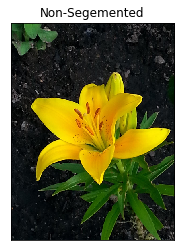

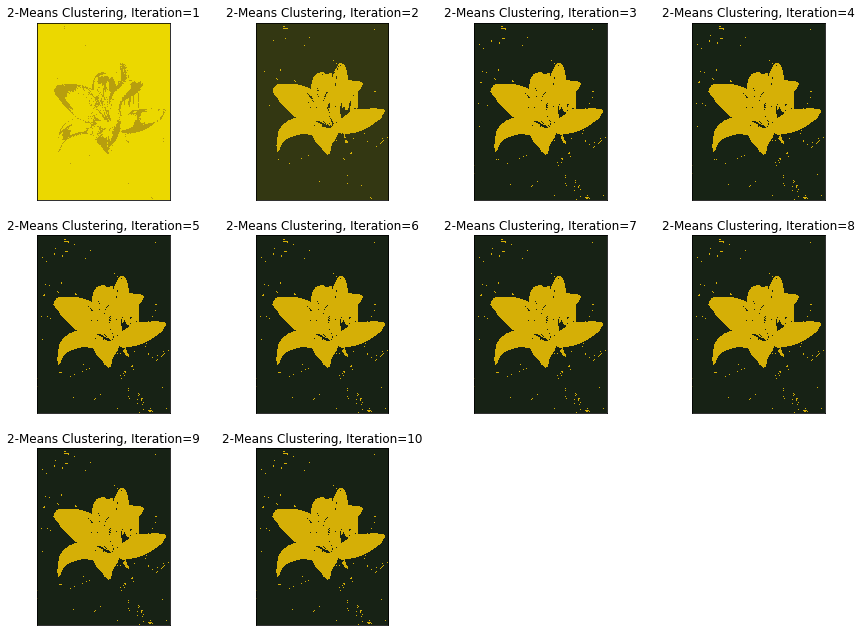

In [2]:
def gen_means(img, k):
    # Randomly assign initial means
    h, w, _ = img.shape
    
    return np.array([ img[np.random.randint(0, h)] # Random Row
                     [np.random.randint(0, w)] # Random Column
                      for i in range(k)]) # For each mean we wish

def k_cluster(img, iterations, k):
    h, w, _ = img.shape
    
    # Randomly assign initial means
    means = gen_means(img, k)
    
    cluster_imgs = list()
    
    for i in range(iterations):
        # Compute difference between all pixels in image and mean for all means
        # distances[means][row][column][channel]
        distances = [img-m for m in means]
        # Normalize to find the distance
        # distances[means][row][column] - channels have been normalized
        distances = np.linalg.norm(np.array(distances), axis=-1)
        
        # Find the mean to which each pixel is closest to
        # clusters[row][column] - clusters contains which cluster each point is assigned to
        clusters = np.argmin(distances, axis=0)
        
        img_copy = img.copy()
        for i in range(len(img)):
            for j in range(len(img[i])):
                img_copy[i][j] = means[clusters[i][j]].copy()
                        
        cluster_imgs.append(img_copy)
        
        # Recalculate means 
        means = np.array([[0,0,0] for i in range(k)])
        for j in range(k):
            for i in range(3):
                means[j][i] = np.mean(img[clusters == j][:,i])
    
    return cluster_imgs
    
img = cv2.cvtColor(cv2.imread('yellowlily.png'), cv2.COLOR_BGR2RGB)
i_list = k_cluster(img, 10, 2)

plt.figure()
plt.imshow(img)
plt.title("Non-Segemented"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
row = 4
col = 4
for i in range(len(i_list)):
    plt.subplot(row, col, i+1)
    plt.imshow(i_list[i])
    plt.title("2-Means Clustering, Iteration={}".format(i+1)), plt.xticks([]), plt.yticks([])
plt.show()    
    

### 1.2 Expectation Maximization - Gaussian Mixture Models
(This takes a while - please be patient)

Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...


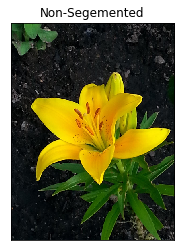

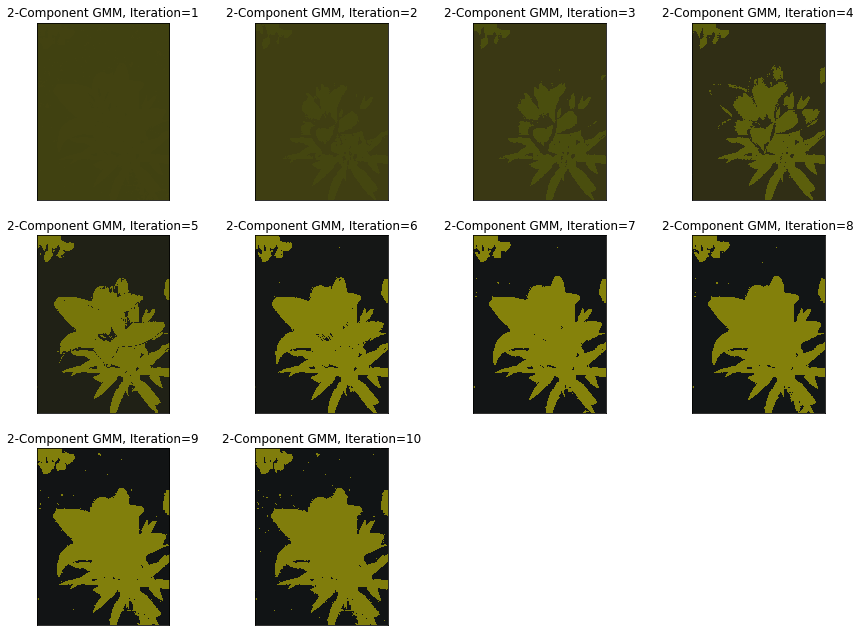

In [4]:
def compute_gauss_prob(pt, cov, mean):
    coeff = 1/(np.sqrt(2*np.pi)*np.sqrt(np.linalg.det(cov)))
    exp = np.exp(-0.5*np.dot(np.dot((pt-mean).T, np.linalg.inv(cov)), (pt-mean)))
    return coeff * exp
    

def expectation_max(img, iterations, k):
    img = img.copy()
    h, w, _ = img.shape
    
    cluster_imgs = list()
    
    # Initialize weights to be equal
    # Size (2, 1)
    weights = np.zeros((2,1))
    weights.fill(1.0/k)
    #print(weights)
    # Generate Random Means
    # Size (2, 3)
    means = gen_means(img, k)
    
    # Initialize Covariances as Identity
    # Size (k, 3, 3)
    cov = np.array([
        np.eye(3) for i in range(k)
    ])
    
    # Size(h, w, k)
    probs = np.zeros((h,w,k))

    # Iterate through pixels
    for it in range(iterations):
        print("Iteration {}...".format(it+1))
        for i, row in enumerate(img):
            for j, pt in enumerate(row):
                # Compute probability that the pixel belongs to a given Gaussian component
                for c in range(k):
                    probs[i][j][c] = weights[c] * compute_gauss_prob(pt, cov[c], means[c])
                # Normalize component probabilities
                probs[i][j] /= sum(probs[i][j])
        
        # Maximization step - compute maximization step to readjust gaussian parameters + weights
        means, weights, cov = maximization(img, probs, means, k)
        
        #np.savetxt('iteration{}-{}.csv'.format(it,0), probs[:,:,0].astype(int), delimiter=',')
        #np.savetxt('iteration{}-{}.csv'.format(it,1), probs[:,:,1].astype(int), delimiter=',')
        clustered = np.argmax(probs, axis=2)
        #np.savetxt('clusterit{}.csv'.format(it), clustered.astype(int), delimiter=',')

        # Segment based on clusters
        img_copy = img.copy()
        for c in range(k):
            for i, row in enumerate(img):
                for j, pixel in enumerate(row):
                    if clustered[i][j] == c:
                        img_copy[i][j] = means[c].copy()
        cluster_imgs.append(img_copy)
    
    return cluster_imgs

def maximization(img, probs, means, k):
    h, w, _ = img.shape
    N = h*w
    
    # Reshape for ease of use
    prob_list = np.reshape(probs, (-1, probs.shape[2]))
    # Sum of component probabilities for each pixel
    sum_probs = prob_list.sum(axis=0)
    
    # New Means
    means_tplus = np.zeros((k, 3))
    for i in range(k):
        m = np.reshape(img, (-1, img.shape[2]))*np.reshape(prob_list[:, i], (-1, 1))
        m = m.sum(axis=0)
        m /= sum_probs[i]
        means_tplus[i] = m
        
    # New Weights    
    weights_tplus = np.array([
        sum_probs[i] / N for i in range(k)
    ])
    
    # New Covariances
    cov_tplus = np.zeros((k, 3, 3))
    for c in range(k):
        for i, row in enumerate(img):
            for j, pixel in enumerate(row):
                delta = (pixel - means[c])[np.newaxis]
                cov_tplus[c] += probs[i][j][c] * np.dot(delta.T, delta)
        cov_tplus[c] /= sum_probs[c]
        
    return means_tplus, weights_tplus, cov_tplus
    
img = cv2.cvtColor(cv2.imread('yellowlily.png'), cv2.COLOR_BGR2RGB)/255
i_list = expectation_max(img, 10, 2)

plt.figure()
plt.imshow(img)
plt.title("Non-Segemented"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
row = 4
col = 4
for i in range(len(i_list)):
    plt.subplot(row, col, i+1)
    plt.imshow(i_list[i])
    plt.title("2-Component GMM, Iteration={}".format(i+1)), plt.xticks([]), plt.yticks([])
plt.show()   

### 1.3 - Reasoning Question
#### Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?
The two clustering approaches would give the same result under the condition of a spherical data distribution. In this case, the EM approach would result in identical covariance matrices across components which would result in the cluster assignment for a given data point relying solely on its distance to the mean - as in the case of K-means.

Similarly, if we have two signals (or images) where the clusters have a large degree of separation, both algorithms would have more ease in identifying these clusters and would likely produce the same (if not extremely similar) result. 

### 2 - Stereovision
#### 2.1 Compute Sift Keypoints

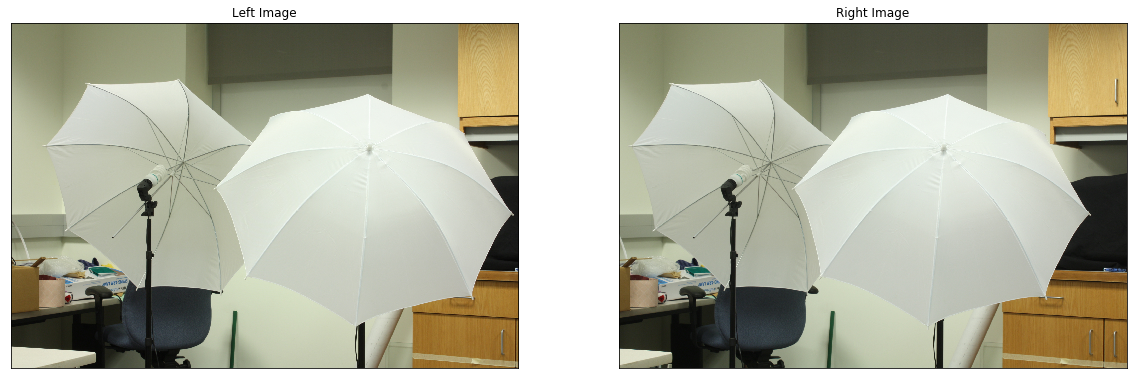

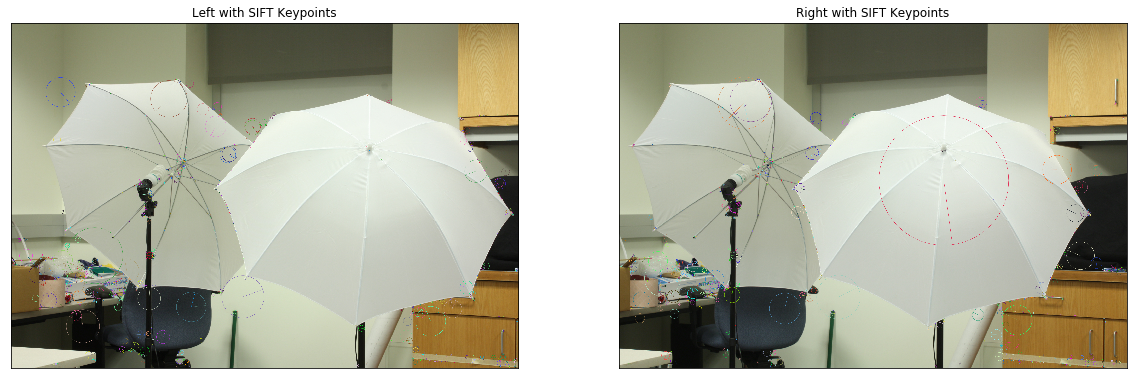

In [3]:
# Load Stereo Images
left = cv2.cvtColor(cv2.imread('im0.png'), cv2.COLOR_BGR2RGB)
right = cv2.cvtColor(cv2.imread('im1.png'), cv2.COLOR_BGR2RGB)

# Fundamental Matrix
sift = cv2.xfeatures2d.SIFT_create()

# Sift keypoints and descriptors
kpLeft, descLeft = sift.detectAndCompute(left, None)
kpRight, descRight = sift.detectAndCompute(right, None)

# Plot Keypoints
leftDisp = left.copy()
rightDisp = right.copy()
cv2.drawKeypoints(left, kpLeft, leftDisp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(right, kpRight, rightDisp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(left)
plt.title("Left Image", fontsize=12), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(right)
plt.title("Right Image", fontsize=12), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(leftDisp)
plt.title("Left with SIFT Keypoints", fontsize=12), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(rightDisp)
plt.title("Right with SIFT Keypoints", fontsize=12), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2 - Compute Epipolar Lines

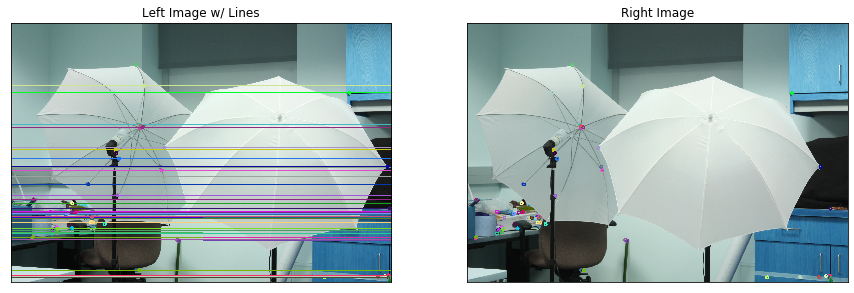

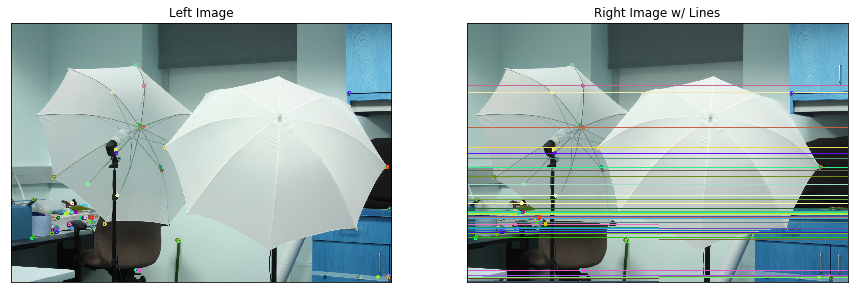

In [4]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    TAKEN FROM TUTORIAL 7 - NOT MY OWN WORK. CREDITS TO TAs
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col, channels = img1.shape
    # Create copy so you don't modify original array
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 3)
        img1 = cv2.circle(img1, tuple(pt1), 10, color, 10)
        img2 = cv2.circle(img2, tuple(pt2), 10, color, 10)
    return img1, img2

# Brute Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# Now, we want to match keypoints and remove matches on repeatative structure.
# match descriptors (find the best two matches for each descriptor)
# K=2 to get 2 best matches for each descriptor
matches = bfMatcher.knnMatch(descLeft, descRight, k=2) # query image, train image

# Lowe's Ratio Test
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.3 * n.distance:
        good.append(m)
        ptsR.append(kpRight[m.trainIdx].pt)
        ptsL.append(kpLeft[m.queryIdx].pt)

# Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) 


# Only use Inliers
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# Plot epilines onto other image
# Compute from points in Right, plot on Left
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
left1, right1 = drawlines(left, right, linesL, ptsL, ptsR)

# Plot epilines onto other image
# Compute from points in Right, plot on Left
linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
right2, left2 = drawlines(right, left, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(left1, cmap="gray")
plt.title("Left Image w/ Lines"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(right1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(left2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(right2, cmap="gray")
plt.title("Right Image w/ Lines"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.3 - Select Keypoint + Patch

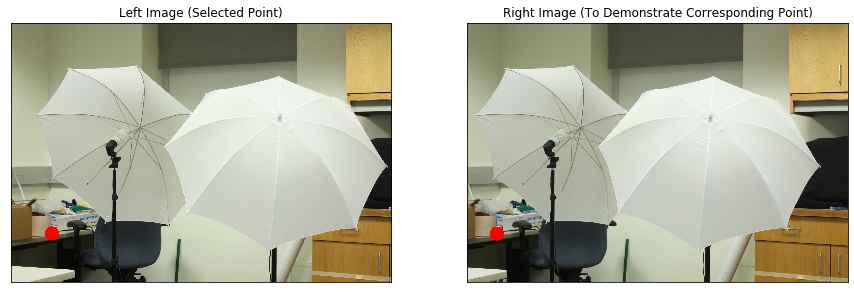

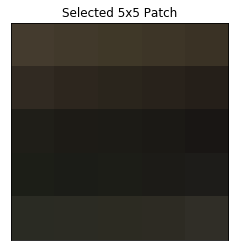

In [5]:
# Select first inlier point from Left Image
selPt = ptsL[4]
left2 = left.copy()
color = (255, 0, 0)
cv2.circle(left2, tuple(selPt), 5, color, 100)

# Show corresponding point on Right Image
selR = ptsR[4]
right2 = right.copy()
color = (255, 0, 0)
cv2.circle(right2, tuple(selR), 5, color, 100)

# Get Patch
col, row = tuple(selPt)
selPatch = left[row-2 : row+3, col-2 : col+3 ]

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(left2, cmap="gray")
plt.title("Left Image (Selected Point)"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(right2, cmap="gray")
plt.title("Right Image (To Demonstrate Corresponding Point)"), plt.xticks([]), plt.yticks([])
plt.show()

# Display Selected Patch
plt.imshow(selPatch, cmap="gray")
plt.title("Selected 5x5 Patch"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.4 - Find Matching Patch on Right Image
Here we use NCC to find a patch on the Right Image matching the selected patch on the Left Image - since the images are stereo, the rows match and we can simply do a horizontal scan on that row

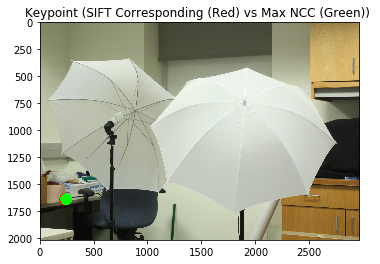

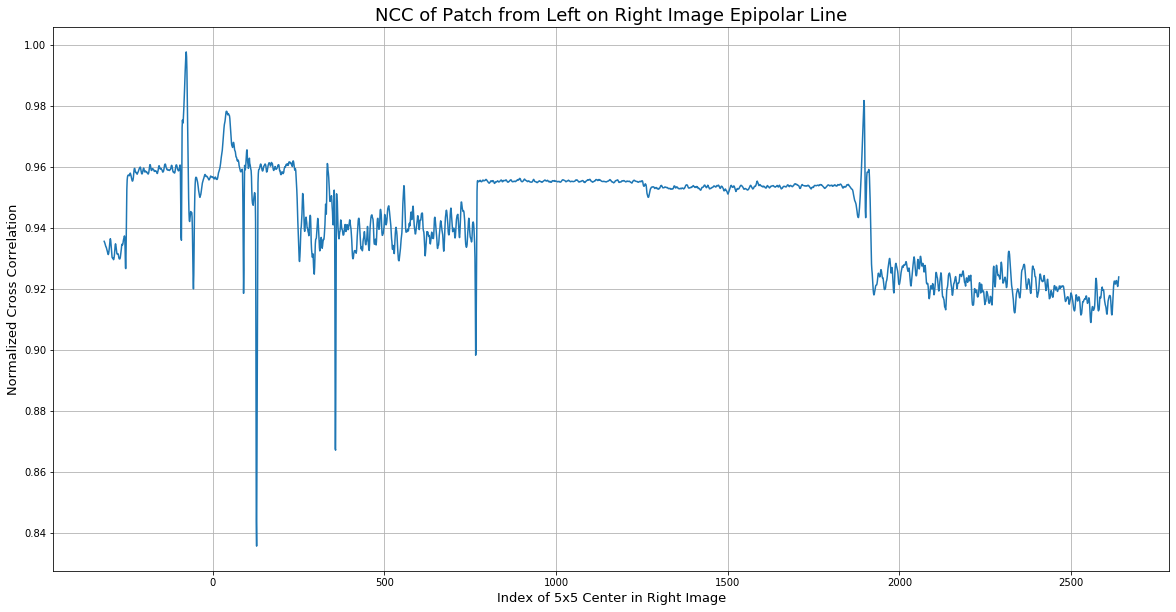

In [6]:
# We're going to keep track of Normalized Cross Correlation and Index
# as well as Max NCC and its corresponding x-coordinate 
ncc = []
ind = []
maxNcc = -1
maxX = 2

right2 = right.copy()

rW = right.shape[1]
for x in range(2, rW-2):
    neigh = right[row-2:row+3, x-2:x+3]
    cur_ncc = cv2.matchTemplate(selPatch, neigh, method=cv2.TM_CCORR_NORMED)[0]
    ncc.append(cur_ncc)
    ind.append(x - col)
    if cur_ncc > maxNcc:
        maxNcc = cur_ncc
        maxX = x
        
# Compare what is found by NCC with what is found by the SIFT Matcher
cv2.circle(right2, tuple(selR), 5, color, 100)
cv2.circle(right2, (maxX, row), 5, (0, 255, 0), 100)
plt.title("Keypoint (SIFT Corresponding (Red) vs Max NCC (Green)) ")
plt.imshow(right2)
        
# Plot NCC against Index
plt.figure(figsize=(20,10))
plt.title("NCC of Patch from Left on Right Image Epipolar Line", fontsize=18)
plt.xlabel("Index of 5x5 Center in Right Image", fontsize=13)
plt.ylabel("Normalized Cross Correlation", fontsize=13)
plt.plot(ind, ncc)
plt.grid(True)
plt.show()

Let's also plot the Selected Patch and compare it with what is found by the NCC Maximization (We find that it is the same patch)

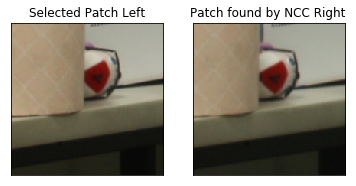

In [7]:
# Original Selected Patch in Left
plt.subplot(121), plt.imshow(left[row-100:row+100, col-100:col+100])
plt.title("Selected Patch Left"), plt.xticks([]), plt.yticks([])

# Corresponding Patch in Right (Found by NCC Max)
plt.subplot(122), plt.imshow(right[row-100:row+100, maxX-100:maxX+100])
plt.title("Patch found by NCC Right "), plt.xticks([]), plt.yticks([])
plt.show()

### 2.5 - Reasoning
> Did you find exactly one matching point or multiple matches? Is the matching point you found the correct one? Explain.

Multiple local maxima were found, however, the global maximum was indeed the correct matching point (as demonstrated above). Note that while, in this case, we were able to correctly identify the matching point (it was the strongest match) it could be the case that the match assumption uniqueness does not hold for our image and, indeed, there are multiple matches for a given keypoint. In this case, we find other local maxima for points that are similar to the selected keypoint in the left image (but not an exact match) - to illustrate this, I plot these points in the cell below, and we can see that the selected patches are indeed similar (but not an exact match) to the selected patch / keypoint.

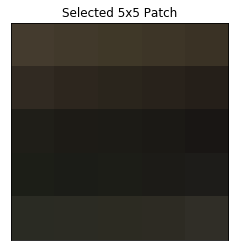

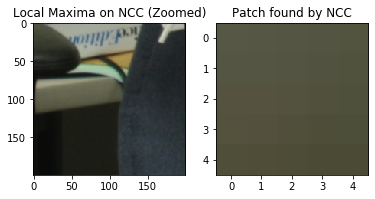

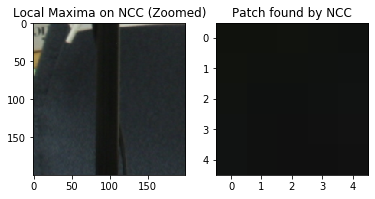

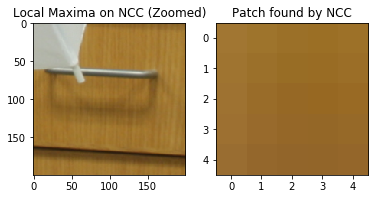

In [8]:
# Selected Patch for Reference
plt.imshow(selPatch, cmap="gray")
plt.title("Selected 5x5 Patch"), plt.xticks([]), plt.yticks([])
plt.show()

# Find all indices where correlation exceed 0.97 (local maxima in the graph above)
closeMatches = []

# Cooldown to avoid picking up the same patch multiple times
cooldown = 0
for idx, corr in enumerate(ncc):
    if cooldown > 0:
        cooldown -= 1
        continue
    if corr > 0.97:
        closeMatches.append(idx + col)
        cooldown = 50

# Display Patches for Loal Maxima
for i in closeMatches:
    plt.subplot(121), plt.imshow(right[row-100:row+100, i-100:i+100])
    plt.title("Local Maxima on NCC (Zoomed)")
    plt.subplot(122), plt.imshow(right[row-2:row+3, i-2:i+3])
    plt.title("Patch found by NCC")
    plt.show()